# Packages import, dir creation, log functions

In [1]:
# import packages
import os
import csv
import random
import tarfile
import multiprocessing as mp

import tqdm
import requests

import numpy as np
import sklearn.model_selection as skms

import torch
import torch.utils.data as td
import torch.nn.functional as F

import torchvision as tv
import torchvision.transforms.functional as TF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# define constants
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
OUT_DIR = 'results'
RANDOM_SEED = 42

# create an output folder
os.makedirs(OUT_DIR, exist_ok=True)


def get_model_desc(pretrained=False, num_classes=200, use_attention=False):
    """
    Generates description string.  
    """
    desc = list()

    if pretrained:
        desc.append('Transfer')
    else:
        desc.append('Baseline')

    if num_classes == 204:
        desc.append('Multitask')

    if use_attention:
        desc.append('Attention')

    return '-'.join(desc)


def log_accuracy(path_to_csv, desc, acc, sep='\t', newline='\n'):
    """
    Logs accuracy into a CSV-file.
    """
    file_exists = os.path.exists(path_to_csv)

    mode = 'a'
    if not file_exists:
        mode += '+'

    with open(path_to_csv, mode) as csv:
        if not file_exists:
            csv.write(f'setup{sep}accuracy{newline}')

        csv.write(f'{desc}{sep}{acc}{newline}')

cuda


In [2]:
import sklearn.metrics as skm

In [3]:
import time

In [4]:
import copy

# Dataset import

In [5]:
class GoogleDriveDownloader(object):
    """
    Downloading a file stored on Google Drive by its URL.
    If the link is pointing to another resource, the redirect chain is being expanded.
    Returns the output path.
    """
    
    base_url = 'https://docs.google.com/uc?export=download'
    chunk_size = 32768
    
    def __init__(self, url, out_dir):
        super().__init__()
        
        self.out_name = url.rsplit('/', 1)[-1]
        self.url = self._get_redirect_url(url)
        self.out_dir = out_dir
    
    @staticmethod
    def _get_redirect_url(url):
        response = requests.get(url)
        if response.url != url and response.url is not None:
            redirect_url = response.url
            return redirect_url
        else:
            return url
    
    @staticmethod
    def _get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None
    
    def _save_response_content(self, response):
        with open(self.fpath, 'wb') as f:
            bar = tqdm.tqdm(total=None)
            progress = 0
            for chunk in response.iter_content(self.chunk_size):
                if chunk:
                    f.write(chunk)
                    progress += len(chunk)
                    bar.update(progress - bar.n)
            bar.close()
    
    @property
    def file_id(self):
        return self.url.split('?')[0].split('/')[-2]
    
    @property
    def fpath(self):
        return os.path.join(self.out_dir, self.out_name)
    
    def download(self):
        os.makedirs(self.out_dir, exist_ok=True)
        
        if os.path.isfile(self.fpath):
            print('File is downloaded yet:', self.fpath)
        else:
            session = requests.Session()
            response = session.get(self.base_url, params={'id': self.file_id}, stream=True)
            token = self._get_confirm_token(response)

            if token:
                response = session.get(self.base_url, params={'id': self.file_id, 'confirm': token}, stream=True)
            else:
                raise RuntimeError()

            self._save_response_content(response)
        
        return self.fpath


# download an archive containing the dataset and store it into the output directory
url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
dl = GoogleDriveDownloader(url, 'data')
dl.download()

1150585339it [00:05, 229774173.60it/s]


'data/CUB_200_2011.tgz'

In [6]:
def extract_tgz(from_path, to_path=None, img_extention='.jpg'):
    """
    Extracts data from '.tgz' file and displays data statistics.
    Returns the output directory name.  
    """
    with tarfile.open(from_path, 'r:gz') as tar:   
        
        if to_path is None:
            out_dir = os.path.splitext(from_path)[0]
        if os.path.isdir(out_dir):
            print('Files are extracted yet.')
        else:
            print('Extracting files...')
        to_path = os.path.dirname(out_dir)

        subdir_and_files = [tarinfo for tarinfo in tar.getmembers()]    
        imgs = [t for t in subdir_and_files if t.name.endswith(img_extention)]
        print('\tClasses: {}\n\tImages: {}'.format(len(set([os.path.dirname(t.name) for t in imgs])), len(imgs)))

        tar.extractall(to_path, members=subdir_and_files)
        
        return out_dir


# extract the downloaded archive & assess data statistics
in_dir_data = extract_tgz(from_path=dl.fpath)
# if manually uploading:
#in_dir_data = extract_tgz(from_path=os.path.join("data", "CUB_200_2011.tgz"))

Extracting files...
	Classes: 200
	Images: 11788


In [7]:
in_dir_img = os.path.join(in_dir_data, 'images')

# Dataset exploration

## Image corruption check

In [ ]:
def get_filepaths(path_to_data, fileformat='.jpg'):
    """
    Ruturns paths to files of the specified format.  
    """             
    filepaths = list()
    for root, _, finenames in os.walk(path_to_data):
        for fn in finenames:
            if fn.endswith(fileformat):
                filepaths.append(os.path.join(root, fn))
                
    return filepaths


def cleaning_worker(path_to_img):
    """
    Verifies whether the image is corrupted.
    """
    std = np.std(mpimg.imread(path_to_img))
    img_ok = not np.isclose(std, 0.0)
    
    return img_ok, path_to_img


# calculate standard deviation of images
imgs_corrupted = list()
with mp.Pool(processes=mp.cpu_count()) as pool:    
    for img_ok, fn in pool.imap_unordered(cleaning_worker, get_filepaths(in_dir_img)):
        if not img_ok:
            imgs_corrupted.append(fn)

# verify do corrupted images (missing data) exist
print('Corrupted images #:', len(imgs_corrupted))

# clean up the images that aren't OK            
# for fn in imgs_corrupted:
#    os.remove(fn)

Corrupted images #: 0


## Similar species

In [ ]:
def plot_simmilar_species(s_name):
  img_sparrows = dict()
  # get all wróble
  sparrows_total = [k for k in os.listdir(in_dir_img) if s_name in k.lower()]
  print("{} species of {} in dataset".format(len(sparrows_total), s_name))
  ####
  some_sparrows = sparrows_total[:5]
  for dirname in some_sparrows:
      imgs = list()
      for dp, _, fn in os.walk(os.path.join(in_dir_img, dirname)):
          imgs.extend(fn)
      img_sparrows[dirname] = imgs
  print(some_sparrows)
  ###
  row_count = 5
  column_count = len(some_sparrows)
  f, ax = plt.subplots(row_count, column_count, figsize=(20, 12))
  f.patch.set_facecolor('white')

  for j in range(row_count):
    for i in range(column_count):
        cls_name = some_sparrows[i]
        img_count = len(img_sparrows[cls_name])
        img_name = img_sparrows[cls_name][j % img_count]
        path_img = os.path.join(os.path.join(in_dir_img, cls_name), img_name)
        ax[j,i].imshow(mpimg.imread(path_img))
        if j == 0:
          ax[j,i].set_title(cls_name.split('.')[-1].replace('_', ' '),  fontsize=15)
        plt.tight_layout()
    plt.tight_layout()
      
  plt.show()

# plot_simmilar_species('sparrow')
# plot_simmilar_species('auklet')
# plot_simmilar_species('blackbird')
plot_simmilar_species('hummingbird')

## Size of images

In [ ]:
# calculate image statistics (takes some time to complete)
ds = tv.datasets.ImageFolder(in_dir_img)
shapes = [(img.height, img.width) for img, _ in ds]
heights, widths = [[h for h,_ in shapes], [w for _,w in shapes]]
print('Average sizes:', *map(np.median, zip(*shapes)))

# visualize the distribution of the size of images
fig = plt.figure()
ax = fig.add_subplot(111)

bp = ax.boxplot([heights, widths], patch_artist=True)

ax.set_xticklabels(['height', 'width'])
ax.set_xlabel('image sizes')
ax.set_ylabel('pixels')

plt.show()

## Average image

In [ ]:
def pad(img, fill=0, size_max=500):
    """
    Pad image to size_max pixels width and height
    """
    pad_height = max(0, size_max - img.shape[1])
    pad_width = max(0, size_max - img.shape[2])
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)


ds = tv.datasets.ImageFolder(in_dir_img, transform=tv.transforms.ToTensor())

# average image
img_mean = np.zeros((3, 500, 500))
for img, _ in tqdm.tqdm(ds):
    img = pad(img)
    img_mean += img.numpy()

img_mean = img_mean / len(ds)

# plot average image  
plt.imshow(np.moveaxis(img_mean, 0, 2))
plt.show()

# Data preparation

## Data loader

In [8]:
class DatasetBirds(tv.datasets.ImageFolder):
    """
    Wrapper for the CUB-200-2011 dataset. 
    Method DatasetBirds.__getitem__() returns tuple of image and its corresponding label.    
    """
    def __init__(self,
                 root,
                 transform=None,
                 target_transform=None,
                 loader=tv.datasets.folder.default_loader,
                 is_valid_file=None,
                 train=True,
                 bboxes=False):

        img_root = os.path.join(root, 'images')

        super(DatasetBirds, self).__init__(
            root=img_root,
            transform=None,
            target_transform=None,
            loader=loader,
            is_valid_file=is_valid_file,
        )

        self.transform_ = transform
        self.target_transform_ = target_transform
        self.train = train
        
        # obtain sample ids filtered by split
        path_to_splits = os.path.join(root, 'train_test_split.txt')
        indices_to_use = list()
        with open(path_to_splits, 'r') as in_file:
            for line in in_file:
                idx, use_train = line.strip('\n').split(' ', 2)
                if bool(int(use_train)) == self.train:
                    indices_to_use.append(int(idx))

        # obtain filenames of images
        path_to_index = os.path.join(root, 'images.txt')
        filenames_to_use = set()
        with open(path_to_index, 'r') as in_file:
            for line in in_file:
                idx, fn = line.strip('\n').split(' ', 2)
                if int(idx) in indices_to_use:
                    filenames_to_use.add(fn)

        img_paths_cut = {'/'.join(img_path.rsplit('/', 2)[-2:]): idx for idx, (img_path, lb) in enumerate(self.imgs)}
        imgs_to_use = [self.imgs[img_paths_cut[fn]] for fn in filenames_to_use]

        _, targets_to_use = list(zip(*imgs_to_use))

        self.imgs = self.samples = imgs_to_use
        self.targets = targets_to_use

        if bboxes:
            # get coordinates of a bounding box
            path_to_bboxes = os.path.join(root, 'bounding_boxes.txt')
            bounding_boxes = list()
            with open(path_to_bboxes, 'r') as in_file:
                for line in in_file:
                    idx, x, y, w, h = map(lambda x: float(x), line.strip('\n').split(' '))
                    if int(idx) in indices_to_use:
                        bounding_boxes.append((x, y, w, h))

            self.bboxes = bounding_boxes
        else:
            self.bboxes = None

    def __getitem__(self, index):
        # generate one sample
        sample, target = super(DatasetBirds, self).__getitem__(index)

        if self.bboxes is not None:
            # squeeze coordinates of the bounding box to range [0, 1]
            width, height = sample.width, sample.height
            x, y, w, h = self.bboxes[index]

            scale_resize = 500 / width
            scale_resize_crop = scale_resize * (375 / 500)

            x_rel = scale_resize_crop * x / 375
            y_rel = scale_resize_crop * y / 375
            w_rel = scale_resize_crop * w / 375
            h_rel = scale_resize_crop * h / 375

            target = torch.tensor([target, x_rel, y_rel, w_rel, h_rel])

        if self.transform_ is not None:
            sample = self.transform_(sample)
        if self.target_transform_ is not None:
            target = self.target_transform_(target)

        return sample, target

## Data transforming

In [9]:

# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))
# pad images to 500 pixels
max_padding = tv.transforms.Lambda(lambda x: pad(x, fill=fill))

In [10]:
# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))

# transform images
transforms_train = tv.transforms.Compose([
   max_padding,
   tv.transforms.RandomOrder([
       tv.transforms.RandomCrop((375, 375)),
       tv.transforms.RandomHorizontalFlip(),
       tv.transforms.RandomVerticalFlip()
   ]),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_eval = tv.transforms.Compose([
   max_padding,
   tv.transforms.CenterCrop((375, 375)),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Data splitting

In [11]:
# instantiate dataset objects according to the pre-defined splits
ds_train = DatasetBirds(in_dir_data, transform=transforms_train, train=True)
ds_val = DatasetBirds(in_dir_data, transform=transforms_eval, train=True)
ds_test = DatasetBirds(in_dir_data, transform=transforms_eval, train=False)

splits = skms.StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
idx_train, idx_val = next(splits.split(np.zeros(len(ds_train)), ds_train.targets))

## Data loader object

In [12]:
# set hyper-parameters
params = {'batch_size': 24, 'num_workers': 2}
num_epochs = 100
num_classes = 200

In [13]:
# instantiate data loaders
train_loader = td.DataLoader(
   dataset=ds_train,
   sampler=td.SubsetRandomSampler(idx_train),
   **params
)
val_loader = td.DataLoader(
   dataset=ds_val,
   sampler=td.SubsetRandomSampler(idx_val),
   **params
)
test_loader = td.DataLoader(dataset=ds_test, **params)

# Visualization of transformations

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [ ]:
torch.max(images)

tensor(2.6400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


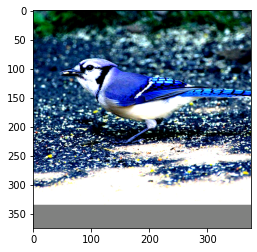

In [ ]:
img = images[8] / 2 + 0.5
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Model building and evaluation

## Model

In [14]:
# instantiate the model
model = tv.models.resnet50(num_classes=num_classes).to(DEVICE)
# model = tv.models.densenet121(num_classes=num_classes).to(DEVICE)
# model

## Training

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [16]:
def pad(img, fill=0, size_max=500):
    pad_height = max(0, size_max - img.height)
    pad_width = max(0, size_max - img.width)
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)

In [17]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}

In [18]:
def train_model(model, dataloaders, optimizer, scheduler, num_epochs):
  model_history = {
      'train' : { 'loss': [], 'acc': []},
      'val' : { 'loss': [], 'acc': []}
  }

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    since = time.time()
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = []
    running_accuracy = []

    for phase in ['train', 'val']:
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode

      # inputs = x, labels = y
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          # predict bird species
          predicted_labels = model(inputs)
          
          # calculate the loss
          loss = F.cross_entropy(predicted_labels, labels)

          # calculate the accuracy
          acc = skm.accuracy_score([val.item() for val in labels], [val.item() for val in predicted_labels.argmax(dim=-1)])
          
          if phase == 'train':
            # backprop & update weights 
            loss.backward()
            optimizer.step()

        running_loss.append(loss.item())
        running_accuracy.append(acc)

      epoch_loss = np.mean(running_loss)
      epoch_acc = np.mean(running_accuracy)
      if phase == 'train':
        model_history['train']['loss'].append(epoch_loss)
        model_history['train']['acc'].append(epoch_acc)
      else:
        model_history['val']['loss'].append(epoch_loss)
        model_history['val']['acc'].append(epoch_acc)

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      time_elapsed = time.time() - since
      print('{} Loss: {:.4f} Acc: {:.4f} Time: {:.0f}m{:.0f}s'.format(phase, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60))

    print()
    # adjust the learning rate
    scheduler.step()

  print('Finished. Best val Acc: {:4f}'.format(best_acc))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, model_history

In [ ]:
# uruchomić tą funkcję na górze z jakimś modelem z odpowienimi parametrami
model, model_history = train_model(model, dataloaders_dict, optimizer, scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 5.3865 Acc: 0.0061 Time: 2m42s
val Loss: 5.3632 Acc: 0.0067 Time: 2m48s

Epoch 1/49
----------
train Loss: 5.1200 Acc: 0.0117 Time: 2m43s
val Loss: 5.1219 Acc: 0.0118 Time: 2m50s

Epoch 2/49
----------
train Loss: 5.0092 Acc: 0.0135 Time: 2m43s
val Loss: 5.0062 Acc: 0.0133 Time: 2m49s

Epoch 3/49
----------
train Loss: 4.9107 Acc: 0.0209 Time: 2m43s
val Loss: 4.9088 Acc: 0.0210 Time: 2m49s

Epoch 4/49
----------
train Loss: 4.8025 Acc: 0.0278 Time: 2m43s
val Loss: 4.8059 Acc: 0.0267 Time: 2m49s

Epoch 5/49
----------
train Loss: 4.6754 Acc: 0.0346 Time: 2m43s
val Loss: 4.7077 Acc: 0.0338 Time: 2m49s

Epoch 6/49
----------
train Loss: 4.5586 Acc: 0.0406 Time: 2m43s
val Loss: 4.6059 Acc: 0.0409 Time: 2m49s

Epoch 7/49
----------
train Loss: 4.4423 Acc: 0.0600 Time: 2m43s
val Loss: 4.4526 Acc: 0.0610 Time: 2m50s

Epoch 8/49
----------
train Loss: 4.3314 Acc: 0.0604 Time: 2m43s
val Loss: 4.3646 Acc: 0.0595 Time: 2m50s

Epoch 9/49
----------
train Loss: 4.2

In [ ]:
# pytorch function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# generate model description string
model_desc = get_model_desc(num_classes=num_classes)

# define the training loop
best_snapshot_path = None
val_acc_avg = list()
best_val_acc = -1.0

for epoch in range(num_epochs):
    
    # train the model
    model.train()
    train_loss = list()
    for batch in train_loader:
        x, y = batch
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        
        # predict bird species
        y_pred = model(x)
        
        # calculate the loss
        loss = F.cross_entropy(y_pred, y)
        
        # backprop & update weights 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
    # validate the model
    model.eval()
    val_loss = list()
    val_acc = list()
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            # predict bird species
            y_pred = model(x)

            # calculate the loss
            loss = F.cross_entropy(y_pred, y)
            
            # calculate the accuracy
            acc = skm.accuracy_score([val.item() for val in y], [val.item() for val in y_pred.argmax(dim=-1)])

            val_loss.append(loss.item())
            val_acc.append(acc)

        val_acc_avg.append(np.mean(val_acc))
            
        # save the best model snapshot
        current_val_acc = val_acc_avg[-1]
        if current_val_acc > best_val_acc:
            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)

            best_val_acc = current_val_acc
            best_snapshot_path = os.path.join(OUT_DIR, f'model_{model_desc}_ep={epoch}_acc={best_val_acc}.pt')

            torch.save(model.state_dict(), best_snapshot_path)
    
    # adjust the learning rate
    scheduler.step()

    # print performance metrics
    print('Epoch {} |> Train. loss: {:.4f} | Val. loss: {:.4f}'.format(
        epoch + 1, np.mean(train_loss), np.mean(val_loss))
    )

## Evaluation

In [ ]:
# load snapshot of the best model
model.load_state_dict(torch.load(best_snapshot_path, map_location=DEVICE))
        
# test the model
true = list()
pred = list()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # predict bird species
        y_pred = model(x)

        true.extend([val.item() for val in y])
        pred.extend([val.item() for val in y_pred.argmax(dim=-1)])

# calculate the accuracy 
test_accuracy = skm.accuracy_score(true, pred)
print('Test accuracy: {:.3f}'.format(test_accuracy))

Test accuracy: 0.312


In [ ]:
# save the accuracy
path_to_logs = f'{OUT_DIR}/logs.csv'
log_accuracy(path_to_logs, model_desc, test_accuracy)

# Testing

In [ ]:
sorted(os.listdir(in_dir_img))

In [ ]:
val_loss
# val_acc_avg